In [79]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np



In [77]:
# Set the visible GPU (e.g., GPU 0)
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')


In [68]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant_village",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [34]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [35]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


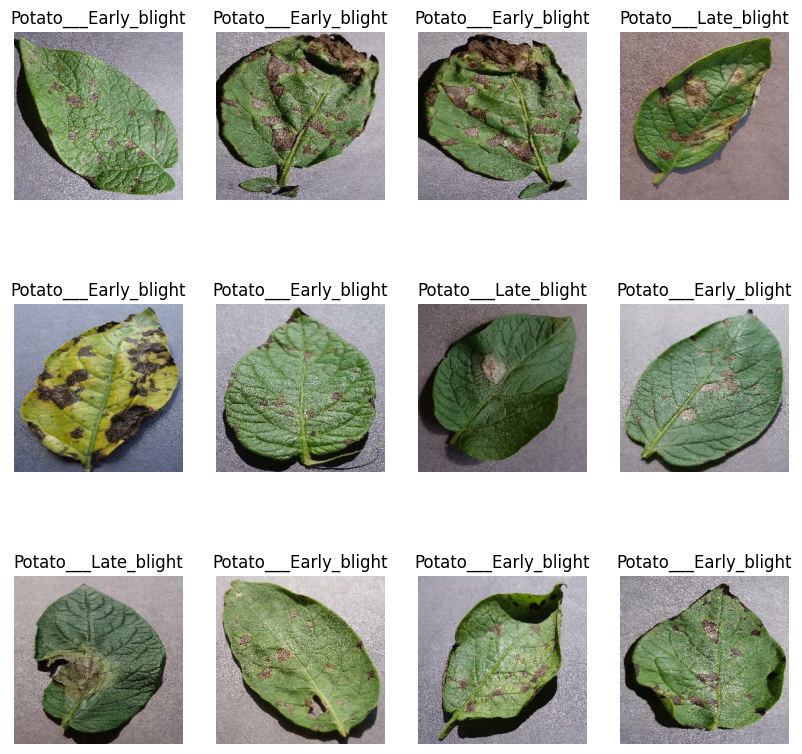

In [36]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [37]:
# Function to Split Dataset
# Dataset should be bifurcated into 3 subsets, namely:

# Training: Dataset to be used while training
# Validation: Dataset to be tested against while training
# Test: Dataset to be tested against after we trained a model

In [38]:
len(dataset)

68

In [39]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [40]:
train_ds = dataset.take(54)
len(train_ds)

54

In [41]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [42]:
val_size=0.1
len(dataset)*val_size


6.800000000000001

In [43]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [46]:
len(train_ds)

54

In [47]:
len(val_ds)

6

In [48]:
len(test_ds)

8

In [49]:
#Cache, Shuffle, and Prefetch the Dataset


In [50]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [51]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [52]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [53]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
#Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [55]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [56]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [57]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 [==============================] - 13s 211ms/step - loss: 0.8381 - accuracy: 0.5914 - val_loss: 0.9320 - val_accuracy: 0.5156
Epoch 2/25
54/54 [==============================] - 9s 171ms/step - loss: 0.5258 - accuracy: 0.7645 - val_loss: 0.4742 - val_accuracy: 0.7760
Epoch 3/25
54/54 [==============================] - 9s 163ms/step - loss: 0.3408 - accuracy: 0.8628 - val_loss: 0.6972 - val_accuracy: 0.7396
Epoch 4/25
54/54 [==============================] - 9s 159ms/step - loss: 0.3010 - accuracy: 0.8825 - val_loss: 0.2440 - val_accuracy: 0.8802
Epoch 5/25
54/54 [==============================] - 9s 161ms/step - loss: 0.2172 - accuracy: 0.9149 - val_loss: 0.2694 - val_accuracy: 0.8958
Epoch 6/25
54/54 [==============================] - 9s 161ms/step - loss: 0.2046 - accuracy: 0.9201 - val_loss: 0.2058 - val_accuracy: 0.9062
Epoch 7/25
54/54 [==============================] - 9s 163ms/step - loss: 0.1716 - accuracy: 0.9311 - val_loss: 0.2292 - val_accuracy: 0.9115
Epoch

In [60]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 32ms/step - loss: 0.1137 - accuracy: 0.9492


In [61]:
scores

[0.11374779790639877, 0.94921875]

In [62]:
history

In [63]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 54}

In [64]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
history.history['accuracy']

[0.5914351940155029,
 0.7644675970077515,
 0.8628472089767456,
 0.8825231194496155,
 0.9149305820465088,
 0.9201388955116272,
 0.9311342835426331,
 0.9392361044883728,
 0.9201388955116272,
 0.9473379850387573,
 0.9357638955116272,
 0.9664351940155029,
 0.9548611044883728,
 0.9768518805503845,
 0.9745370149612427,
 0.9473379850387573,
 0.9716435074806213,
 0.9762731194496155,
 0.9866898059844971,
 0.9664351940155029,
 0.9866898059844971,
 0.9774305820465088,
 0.9832175970077515,
 0.9866898059844971,
 0.9809027910232544]

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

<function matplotlib.pyplot.show(close=None, block=None)>

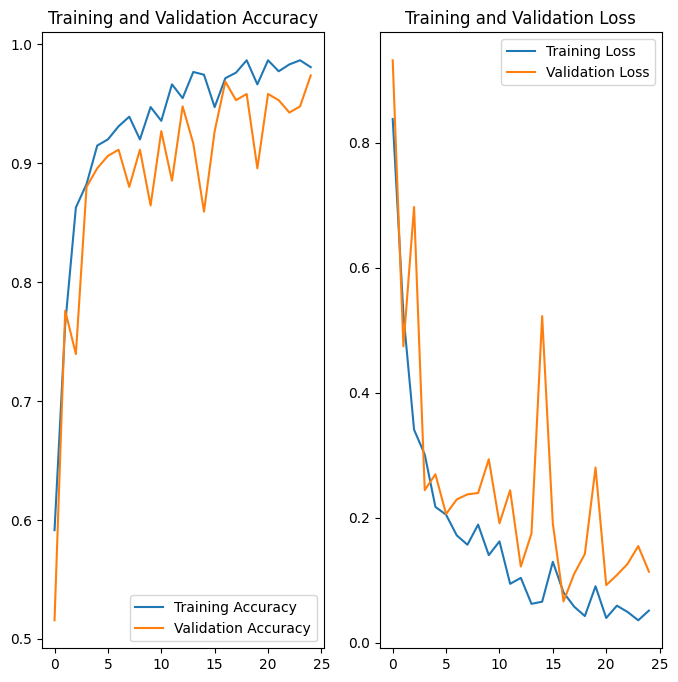

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label= "Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label= "Validation Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 41ms/step
predicted label: Potato___Early_blight


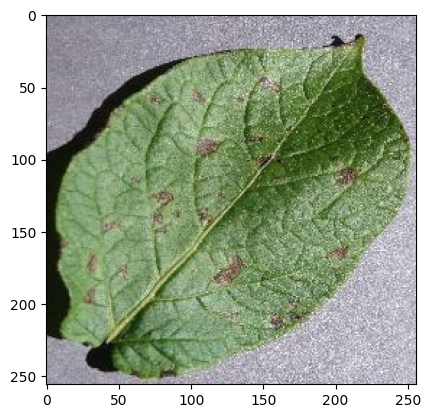

In [93]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [96]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0 ) #create a batch

    predictions = model.predict(img_array)

    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
    

1/1 [==============================] - 0s 19ms/step


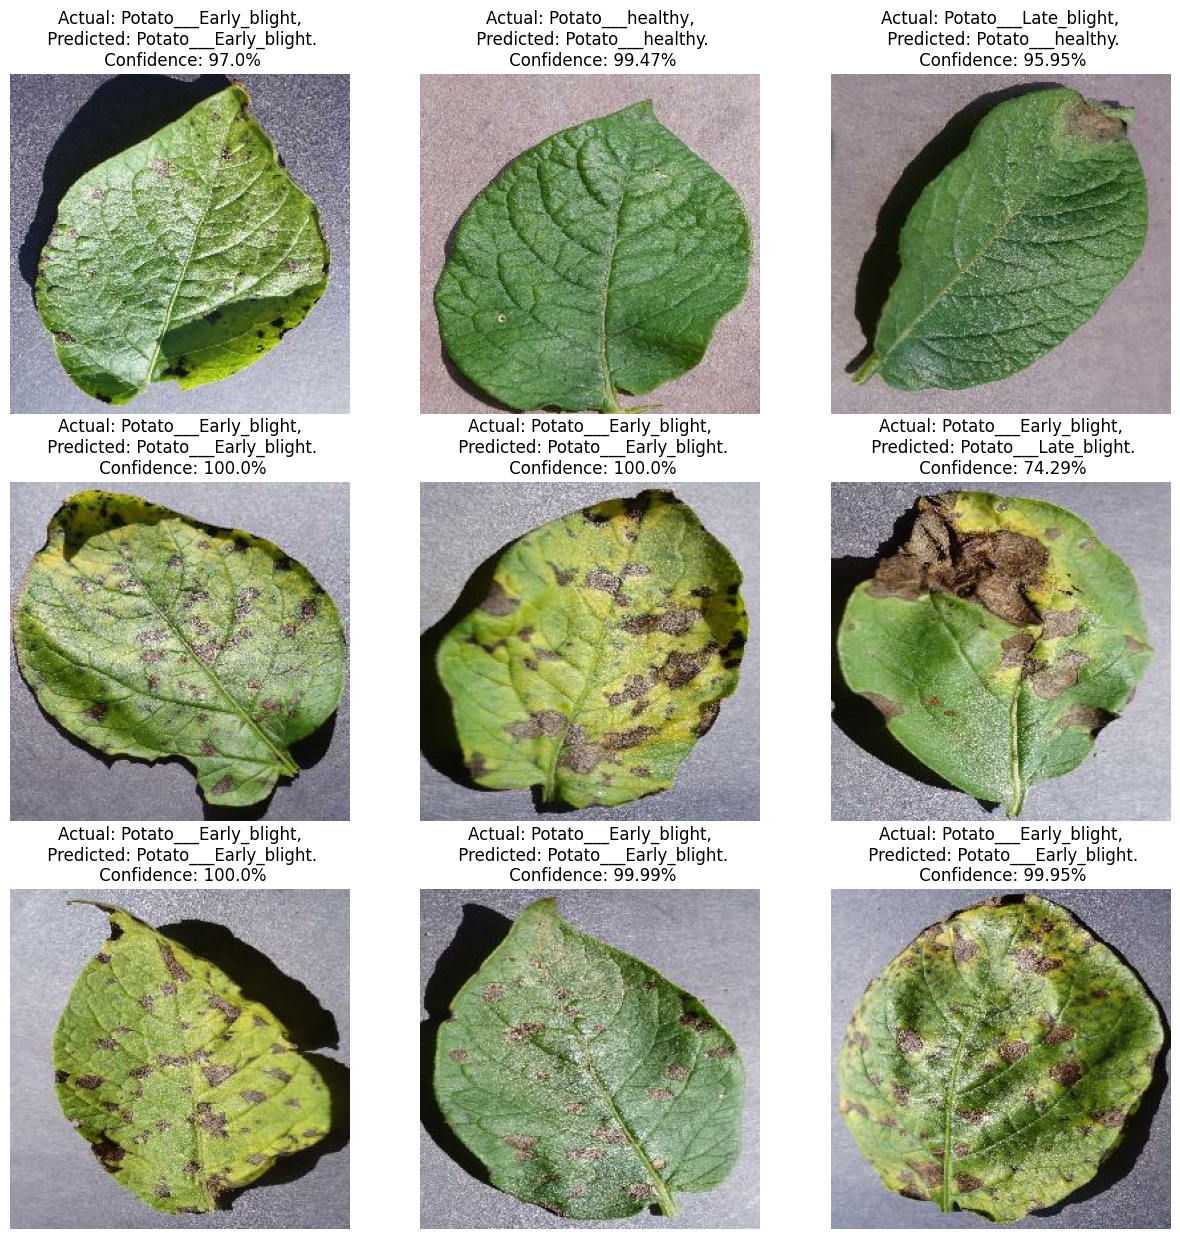

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [100]:
model_version=1
model.save("C:/Users/Shahnawaz/OneDrive/Desktop/Projects/potato Disease classification/models")

INFO:tensorflow:Assets written to: C:/Users/Shahnawaz/OneDrive/Desktop/Projects/potato Disease classification/models\assets


INFO:tensorflow:Assets written to: C:/Users/Shahnawaz/OneDrive/Desktop/Projects/potato Disease classification/models\assets


In [101]:
model.save("../potatoes.h5")